## 0.  Imports

In [1]:
import os
os.chdir('..')
# print(os.getcwd().replace("\\", "/")+"/")
ROOT_PATH = os.getcwd().replace("\\", "/")+"/"

In [2]:
from src.logger_setup import Setup

# The rest of packages
import configparser
import json
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import missingno as msno

## 1. Handling missing data, Data Cleaning

In [3]:
class TrainCleaning:

    def __init__(self) -> None:
        self.setup = Setup()
        self.config = self.setup.config
        self.logger = logging.getLogger("TrainCleaning")
        self.raw_path = self.setup.ROOT_PATH + self.config["raw"]["RawDFDir"]

    def to_pickle(self, compression=None) -> int:
        raw_dir_abs_path = self.setup.ROOT_PATH + self.config["raw"]["RawDFDir"]
        raw_files = os.listdir(raw_dir_abs_path)
        csvs = [raw_dir_abs_path + f for f in raw_files if f.endswith(".csv")]
        for path in csvs:
            self.logger.info(path)
            df = pd.read_csv(path)
            self.logger.info(f"{self.config['raw']['TrainPkl']}")
            df.to_pickle(path=self.config['raw']['TrainPkl'], compression=compression)

        return 0

    def get_missing_data_statistics(self, plot_name="RawDataNABar") -> int:
        with open(f"{self.config['raw']['TrainPkl']}", "rb") as handle:
            df_train_raw = pickle.load(handle)
        fig = plt.figure()
        msno.bar(df_train_raw, figsize=(10, 4), fontsize=8)
        if not os.path.exists("reports/"):
            os.mkdir("reports/")
        fig.savefig(f"reports/{plot_name}.pdf", bbox_inches="tight")

        return 0

2023-02-22 00:42:12 Root Path: c:/Users/user/Documents/Projects/KaggleDruzyna/SpaceshipTitanic/
2023-02-22 00:42:12 c:/Users/user/Documents/Projects/KaggleDruzyna/SpaceshipTitanic/data/raw/sample_submission.csv
2023-02-22 00:42:12 data/raw/train.pkl
2023-02-22 00:42:12 c:/Users/user/Documents/Projects/KaggleDruzyna/SpaceshipTitanic/data/raw/test.csv
2023-02-22 00:42:12 data/raw/train.pkl
2023-02-22 00:42:12 c:/Users/user/Documents/Projects/KaggleDruzyna/SpaceshipTitanic/data/raw/train.csv
2023-02-22 00:42:12 data/raw/train.pkl


0

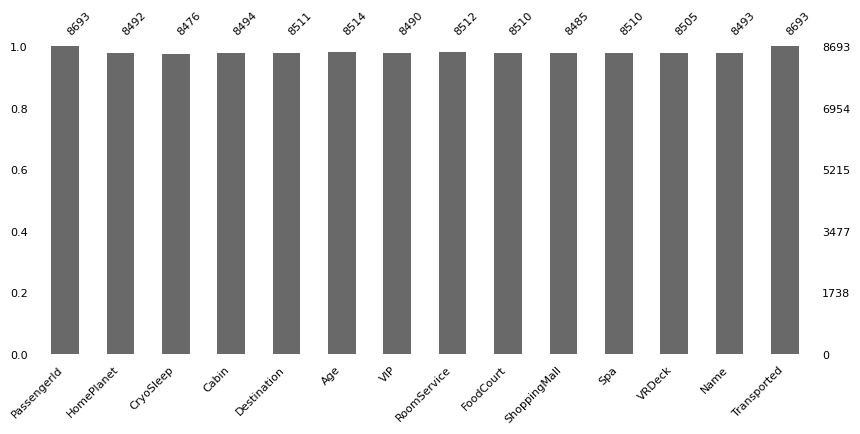

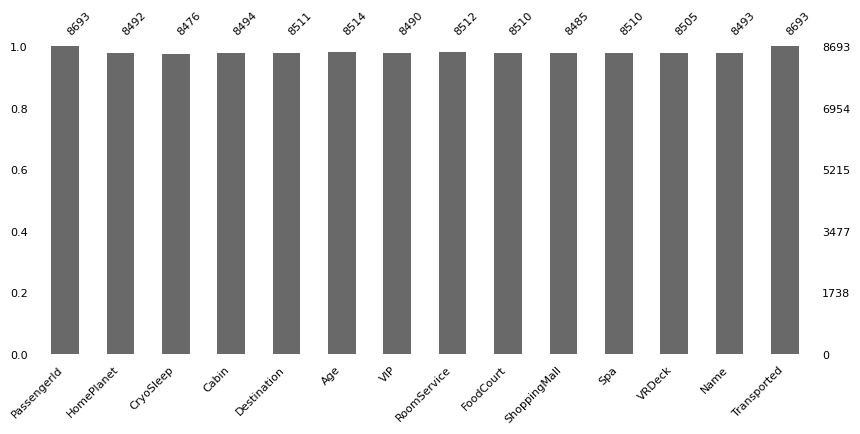

In [4]:
tc = TrainCleaning()
tc.to_pickle()
tc.get_missing_data_statistics()

## 2. Data Transformation

In [7]:
with open(f"data/raw/train.pkl", "rb") as handle:
    df_train_raw = pickle.load(handle)
x = lambda m: m.str.split('/', expand=True)
new_df = x(df_train_raw['Cabin'])
new_df = new_df.rename(columns={0: 'Deck', 1: 'Number', 2:'Side'})
df = pd.concat([df_train_raw, new_df], axis=1)

In [8]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [9]:
df.HomePlanet.value_counts(dropna=False)

Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: HomePlanet, dtype: int64

In [11]:
x = lambda m: m.str.split(' ', expand=True)
df_surname = x(df['Name'])
df_surname = df_surname.rename(columns={0: 'Name', 1: 'Surname'})

In [12]:
family2plot = df_surname["Surname"].value_counts().to_frame().head(20)
family2plot.reset_index(inplace=True)
family2plot.rename(columns={"index":"Surname", "Surname":"Count"}, inplace=True)

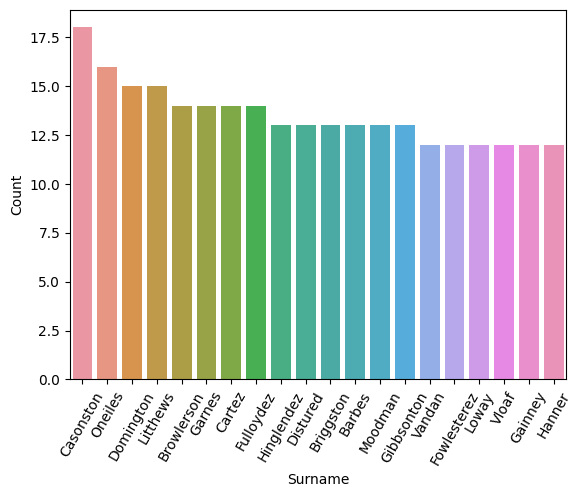

In [13]:
fig, ax = plt.subplots()
chart = sns.barplot(data=family2plot, ax=ax, x="Surname", y="Count")
ax.set_xticklabels(labels=family2plot["Surname"], rotation=60)
plt.show()

## 3. Dimensionality Reduction